# Preparation fot evaluating Google search volume indices

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import datetime
import pickle
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

sys.path.append("../../src")
from ftrends.construction import RBC

import data

In [3]:
# endogenous
file = Path("../../data/raw/macro/ICSA.csv")
df_endog = pd.read_csv(file, index_col=0)
df_endog.index = pd.to_datetime(df_endog.index)

# exogenous
file = Path("../../data/raw/google/weekly/unemployment-office/svi_cat0.pkl")
with file.open(mode="rb") as f:
    dfs = pickle.load(f)
rbc = RBC(dfs)
df_exog = rbc.knit(direction="forward")
df_exog.index = pd.to_datetime(df_exog.index).map(lambda x: x + relativedelta(days=6))


endog, exog = "IC", "SVI"
df = pd.concat([df_endog, df_exog], axis=1) # Concatenate
df.dropna(how='any', inplace=True) # Drop NaN
df.rename(columns = dict(zip(df.columns, [endog, exog])), inplace=True) # Rename

display(df.tail())

,IC,SVI
date,,
2022-09-10,208000.0,5.951570
2022-09-17,209000.0,6.941553
2022-09-24,190000.0,6.941553
2022-10-01,219000.0,6.941553
2022-10-08,228000.0,6.941553


Seasonal adjustment

In [4]:
def seasonal_adjust(df:pd.DataFrame, factor:str, **stl_kwargs:dict):
    res = STL(df[factor], **stl_kwargs).fit()
    df["SVI"] = res.trend

def remove_covid(df:pd.DataFrame):
    covid_start = datetime.datetime(2020, 1, 1)
    return df[df.index < covid_start]

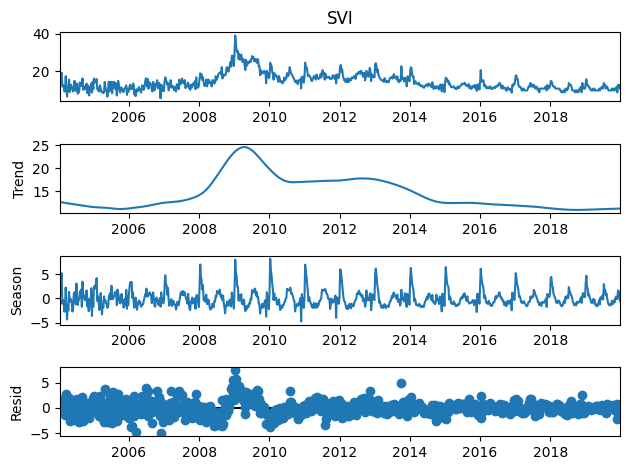

In [5]:
_df = df.copy()
_df = remove_covid(_df) # remove COVID-19 interval
res = STL(_df[exog], robust=False).fit()
res.plot()
plt.show()

Correlation

In [6]:
_df = df.copy()
_df = remove_covid(_df)
seasonal_adjust(_df, exog)
lags = range(-11, 12)
for lag in lags:
    _df[f"{lag}"] = _df["SVI"].shift(lag)

df_corr = _df.corr().loc['IC'].to_frame().loc[[f"{lag}" for lag in reversed(lags)], :]
display(df_corr.T)

,11,10,9,8,7,6,5,4,3,2,...,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11
IC,0.89982,0.90189,0.903744,0.905284,0.906518,0.907382,0.907991,0.90808,0.90793,0.907717,...,0.904277,0.902824,0.901092,0.89912,0.896873,0.894337,0.891541,0.888511,0.885217,0.881693


ADF test

In [7]:
def _ADF(data:pd.Series):
    regressions = ['c', 'ct', 'ctt', 'n']
    summary = ""
    for regression in regressions:
        res = adfuller(data, regression=regression, autolag="AIC")
        significance = 0.05
        summary += "regression:{}, p:{:.3f}, presence of unit roots:{}\n".format(
            regression, res[1], res[1] > significance
        )
    return summary

_df = df.copy()
_df = remove_covid(_df) # Remove COVID-19
seasonal_adjust(_df, exog) # Seasonal adjusted

# original
for col in _df.columns:
    print(col)
    res = _ADF(_df[col])
    print(res)
    
# 1st_diff
for col in _df.columns:
    print(col)
    if col == endog:
        res = _ADF(np.log(_df[col]).diff(1).dropna())
    if col == exog:
        res = _ADF(_df[col].diff(1).dropna())
    print(res)

IC
regression:c, p:0.709, presence of unit roots:True
regression:ct, p:0.734, presence of unit roots:True
regression:ctt, p:0.857, presence of unit roots:True
regression:n, p:0.351, presence of unit roots:True

SVI
regression:c, p:0.419, presence of unit roots:True
regression:ct, p:0.579, presence of unit roots:True
regression:ctt, p:0.662, presence of unit roots:True
regression:n, p:0.533, presence of unit roots:True

IC
regression:c, p:0.000, presence of unit roots:False
regression:ct, p:0.000, presence of unit roots:False
regression:ctt, p:0.000, presence of unit roots:False
regression:n, p:0.000, presence of unit roots:False

SVI
regression:c, p:0.003, presence of unit roots:False
regression:ct, p:0.011, presence of unit roots:False
regression:ctt, p:0.033, presence of unit roots:False
regression:n, p:0.000, presence of unit roots:False



Granger causality test

In [8]:
_df = df.copy()
_df = remove_covid(_df) # Remove COVID-19
seasonal_adjust(_df, exog) # Seasonal adjusted
_df[endog] = np.log(_df[endog]).diff(1) # logarithm ratio
_df[exog] = _df[exog].diff(1) # difference
_df.dropna(how="any", inplace=True)

res = VAR(_df).fit(maxlags=1) # VAR(1)

# endog -> exog
test_result = res.test_causality(caused=1, causing=0)
print(test_result.summary())

# exog -> endog
test_result = res.test_causality(caused=0, causing=1)
print(test_result.summary())

Granger causality F-test. H_0: IC does not Granger-cause SVI. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
       0.04670          3.847   0.829 (1, 1658)
-----------------------------------------------
Granger causality F-test. H_0: SVI does not Granger-cause IC. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         7.202          3.847   0.007 (1, 1658)
-----------------------------------------------
